In [2]:
import numpy as np

# 查看预训练好的文件
# npy文件
vgg16_data = np.load('./data/style_transfer_data/vgg16.npy', encoding='latin1')
print(type(vgg16_data))
print(vgg16_data)

<class 'numpy.ndarray'>
{'conv5_1': [array([[[[-6.0689339e-04,  1.4231558e-03,  7.3316055e-03, ...,
           2.6178278e-03,  4.3357504e-04, -2.9434897e-03],
         [-4.8605306e-03,  4.9075234e-04, -1.2511463e-03, ...,
           1.1560039e-03, -1.2683710e-04, -1.5934335e-02],
         [ 8.2136225e-03,  7.4967248e-03,  4.4443067e-03, ...,
          -1.0573096e-02, -1.3803735e-02, -2.0028956e-03],
         ...,
         [ 2.0234480e-03, -5.8380342e-03, -2.3825851e-03, ...,
           1.3192679e-03, -8.6920448e-03, -8.2156417e-04],
         [ 7.9414165e-03, -8.0086980e-03,  7.7348115e-04, ...,
           9.1014095e-03,  6.8836473e-04, -9.8630879e-03],
         [ 7.3094536e-03, -1.1607672e-03,  5.1686643e-03, ...,
          -1.8046533e-03, -7.7111748e-05,  3.5778836e-03]],

        [[-1.5249068e-03, -3.1574788e-03,  4.5571220e-03, ...,
          -8.1634670e-03, -8.1500728e-03, -5.8323247e-03],
         [-1.2195857e-03, -5.4482273e-03, -8.4939813e-03, ...,
           1.3417795e-03, -1.3

In [3]:
data_dict = vgg16_data.item()
print(data_dict.keys())
print(len(data_dict))

dict_keys(['conv5_1', 'fc6', 'conv5_3', 'conv5_2', 'fc8', 'fc7', 'conv4_1', 'conv4_2', 'conv4_3', 'conv3_3', 'conv3_2', 'conv3_1', 'conv1_1', 'conv1_2', 'conv2_2', 'conv2_1'])
16


In [4]:
conv1_1 = data_dict['conv1_1']
print(len(conv1_1))
w, b = conv1_1
print(w.shape)
print(b.shape)

2
(3, 3, 3, 64)
(64,)


In [5]:
fc6 = data_dict['fc6']
print(len(fc6))
w, b = fc6
print(w.shape)
print(b.shape)

2
(25088, 4096)
(4096,)


# 算法实现
模型文件是预训练好的文件，但是文件是npy文件，不是tensorflow的模型文件。需要使用其他方法

In [6]:
import os
import math
import numpy as np
import tensorflow as tf
from PIL import Image
import time

In [7]:
# 归一化时RGB通道上的均值
VGG_MEAN = [103.939, 116.779, 123.68]

class VGGNet:
    """
    Builds VGG-16 net structure,
    load parameters from pre-train models.
    """
    def __init__(self, data_dict):
        self.data_dict = data_dict
        
    def get_conv_filter(self, name):
        '''name: 'conv1_1', 'conv1_2'...'''
        # tf.constant这里的思路和设置层的是后设置trainable=False一样
        return tf.constant(self.data_dict[name][0], name='conv')
        
    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name='fc')
    
    def get_bias(self, name):
        return tf.constant(self.data_dict[name][1], name='bias')
    
    def conv_layer(self, x, name):
        """Builds convolution layer."""
        with tf.name_scope(name):
            conv_w = self.get_conv_filter(name)
            conv_b = self.get_bias(name)
            # 相比于layers更底层的卷积方式，可以传入自定义参数
            h = tf.nn.conv2d(x, conv_w, [1,1,1,1], padding='SAME')
            h = tf.nn.bias_add(h, conv_b)
            h = tf.nn.relu(h)
            return h
    
    def pooling_layer(self, x, name):
        """Builds pooling layer."""
        return tf.nn.max_pool(x,
                              ksize = [1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME',
                              name = name)
    
    def fc_layer(self, x, name, activation=tf.nn.relu):
        """Builds fully-connected layer."""
        with tf.name_scope(name):
            fc_w = self.get_fc_weight(name)
            fc_b = self.get_bias(name)
            h = tf.matmul(x, fc_w)
            h = tf.nn.bias_add(h, fc_b)
            # 输出值进入softmax，不需要进行activation
            if activation is None:
                return h
            else:
                return activation(h)
    
    def flatten_layer(self, x, name):
        """Builds flatten layer."""
        with tf.name_scope(name):
            # [batch_size, image_width, image_height, channel]
            x_shape = x.get_shape().as_list()
            dim = 1
            for d in x_shape[1:]:
                dim *= d
            x = tf.reshape(x, [-1, dim])
            return x
    
    def build(self, x_rgb):
        """Build VGG16 network structure.
        Parameters:
        - x_rgb: [1, 224, 224, 3]
        """
        start_time = time.time()
        print('building model ...')
        
        # 首先处理输入数据，减去VGG_MEAN(切分三个通道)
        r, g, b = tf.split(x_rgb, [1,1,1], axis=3)
        # VGG按照BGR排列
        x_bgr = tf.concat(
                        [b - VGG_MEAN[0],
                         g - VGG_MEAN[1],
                         r - VGG_MEAN[2]],
                        axis=3)
        
        assert x_bgr.get_shape().as_list()[1:] == [224, 224, 3]
        
        # conv1_1这里的名字需要和npy文件的keys对应
        # 每一层输出定义到成员变量中，在进行风格转换计算时可以直接获得
        self.conv1_1 = self.conv_layer(x_bgr, 'conv1_1')
        self.conv1_2 = self.conv_layer(self.conv1_1, 'conv1_2')
        self.pool1 = self.pooling_layer(self.conv1_2, 'pool1')
        
        self.conv2_1 = self.conv_layer(self.pool1, 'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1, 'conv2_2')
        self.pool2 = self.pooling_layer(self.conv2_2, 'pool2')
        
        self.conv3_1 = self.conv_layer(self.pool2, 'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1, 'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2, 'conv3_3')
        self.pool3 = self.pooling_layer(self.conv3_3, 'pool3')
        
        self.conv4_1 = self.conv_layer(self.pool3, 'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1, 'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2, 'conv4_3')
        self.pool4 = self.pooling_layer(self.conv4_3, 'pool4')
        
        self.conv5_1 = self.conv_layer(self.pool4, 'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1, 'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2, 'conv5_3')
        self.pool5 = self.pooling_layer(self.conv5_3, 'pool5')
        
        '''
        # 在风格转换算法中，并不需要全连接层的数据，并且在构建计算图时在这部分
        # 的文件读取和变量赋值操作很耗时（参数量很大），所以不考虑
        # 21s到0s（不到1s）的缩减时间
        self.flatten5 = self.flatten_layer(self.pool5, 'flatten')
        self.fc6 = self.fc_layer(self.flatten5, 'fc6')
        self.fc7 = self.fc_layer(self.fc6, 'fc7')
        # 输出值进入softmax，不需要进行activation
        self.fc8 = self.fc_layer(self.fc7, 'fc8', activation=None)
        self.prob = tf.nn.softmax(self.fc8, name='prob')
        '''

        print('building model finished: %4ds' % (time.time() - start_time))

In [8]:
# 参数设置
vgg16_npy_path = './data/style_transfer_data/vgg16.npy'
content_img_path = './data/style_transfer_data/gugong.jpg'
style_img_path = './data/style_transfer_data/xingkong.jpeg'

num_steps = 100
learning_rate = 10

# lambda_c：loss content系数
# lambda_s：loss style系数
# loss style在计算gram矩阵的时候除以了维度constant，导致数量级较小
lambda_c = 0.1
lambda_s = 500

output_dir = './run_style_transfer'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

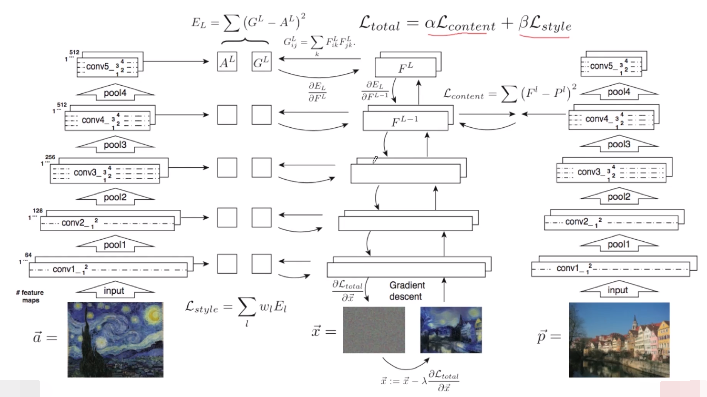

In [10]:
# 风格转换算法实现

# 随机初始化一张图片，通过学习过程一步步更新
def initial_result(shape, mean, stddev):
    initial = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    return tf.Variable(initial)

def read_img(img_name):
    img = Image.open(img_name)
    np_img = np.array(img)  # (224, 224, 3)
    np_img = np.asarray([np_img], dtype=np.int32) # (1, 224, 224, 3)
                                                  # 将[]列表这一维加入
    return np_img

def gram_matrix(x):
    """Calulates gram matrix
    Args:
    - x: feaures extracted from VGG Net. shape: [1, width, height, ch]
    """
    b, w, h, ch = x.get_shape().as_list()
    features =  tf.reshape(x, [b, w*h, ch])   # [ch, ch] -> (i, j)
    # 选择两列计算余弦相似度
    # [h*w, ch] matrix -> [ch, h*w] * [h*w, ch] -> [ch, ch]
    # 除以维度，防止(高维造成的)过大
    gram = tf.matmul(features, features, adjoint_a=True) \
           / tf.constant(ch * w * h, tf.float32) 
    return gram
  
    
# 初始化目标图像
result = initial_result((1, 224, 224, 3), 127.5, 20)

# 读取内容图像，内容图像
content_val = read_img(content_img_path)
style_val = read_img(style_img_path)

# 创建placeholder，通过feed_dict传入
content = tf.placeholder(tf.float32, shape=[1, 224, 224, 3])
style = tf.placeholder(tf.float32, shape=[1, 224, 224, 3])

# 通过三个VGG net提取三个图片特征
data_dict = np.load(vgg16_npy_path, encoding='latin1').item()
vgg_for_content = VGGNet(data_dict)
vgg_for_style = VGGNet(data_dict)
vgg_for_result = VGGNet(data_dict)

# 输入图片数据
vgg_for_content.build(content)
vgg_for_style.build(style)
vgg_for_result.build(result)


# content特征部分
# content_features在离输入层近的层会比较接近content原图（抽象程度更高）
# 可以使用多层
content_features = [
    vgg_for_content.conv1_2,
    vgg_for_content.conv2_2,
    # vgg_for_content.conv3_3,
    # vgg_for_content.conv4_3,
    # vgg_for_content.conv5_3
    ]

result_content_features = [
    vgg_for_result.conv1_2,
    vgg_for_result.conv2_2,
    # vgg_for_result.conv3_3,
    # vgg_for_result.conv4_3,
    # vgg_for_result.conv5_3
    ]


# style特征部分
# 第五层学习效果较差
# feature_size, [1, width, height, channel]
# 可以使用多层
style_features = [
    # vgg_for_style.conv1_2,
    # vgg_for_style.conv2_2,
    # vgg_for_style.conv3_3,
    vgg_for_style.conv4_3,
    # vgg_for_style.conv5_3
    ]
# 每个channel两两计算余弦相似度构成gram矩阵
style_gram = [gram_matrix(feature) for feature in style_features]

# result_style_features需要和style_features的层次保持一致
result_style_features = [
    # vgg_for_result.conv1_2,
    # vgg_for_result.conv2_2,
    # vgg_for_result.conv3_3,
    vgg_for_result.conv4_3,
    # vgg_for_result.conv5_3
    ]
result_style_gram = \
    [gram_matrix(feature) for feature in result_style_features]
    

# 损失函数计算
# content_loss可以对多层求，并添加各层权重（添加一个列表）
content_loss = tf.zeros(1, tf.float32)
# zip: [1, 2], [3, 4], zip([1,2], [3,4]) -> [(1, 3), (2, 4)]
# shape: [1, width, height, channel]
# 对应层次对应位置配对成元组
for c, c_ in zip(content_features, result_content_features):
    content_loss += tf.reduce_mean((c - c_) ** 2, [1, 2, 3])

# style_loss
# style_loss可以对多层求，并添加各层权重（添加一个列表）
style_loss = tf.zeros(1, tf.float32)
for s, s_ in zip(style_gram, result_style_gram):
    style_loss += tf.reduce_mean((s - s_) ** 2, [1, 2])

loss = content_loss * lambda_c + style_loss * lambda_s
with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

building model ...
building model finished:    0s
building model ...
building model finished:    0s
building model ...
building model finished:    0s


In [11]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for step in range(num_steps):
        loss_value, content_loss_value, style_loss_value, _ = \
            sess.run([loss, content_loss, style_loss, train_op],
                    feed_dict={
                        content: content_val,
                        style: style_val,
                    })
        # loss_value,content_loss_value,style_loss_value创建为
        # tf.zeros(1, tf.float32)数组，[0]取出value
        print(
            'step: %d, loss_value: %8.4f, content_loss: %8.4f, style_loss: %8.4f'
            % (step + 1, 
               loss_value[0], 
               content_loss_value[0],
               style_loss_value[0])
            )
        # 输出生成的图像
        result_img_path = os.path.join(
            output_dir, 'result-%05d.jpg' % (step + 1))
        result_val = result.eval(sess)[0]
        result_val = np.clip(result_val, 0, 255)
        img_arr = np.asarray(result_val, np.uint8)
        img = Image.fromarray(img_arr)
        img.save(result_img_path)

step: 1, loss_value: 35091.4648, content_loss: 268747.9375, style_loss:  16.4333
step: 2, loss_value: 28411.4766, content_loss: 206761.8281, style_loss:  15.4706
step: 3, loss_value: 22975.2500, content_loss: 167315.9688, style_loss:  12.4873
step: 4, loss_value: 19088.9570, content_loss: 144730.8750, style_loss:   9.2317
step: 5, loss_value: 16776.0234, content_loss: 130559.6406, style_loss:   7.4401
step: 6, loss_value: 15488.1699, content_loss: 120709.3594, style_loss:   6.8345
step: 7, loss_value: 14927.4766, content_loss: 113195.4688, style_loss:   7.2159
step: 8, loss_value: 13387.2109, content_loss: 106586.9375, style_loss:   5.4570
step: 9, loss_value: 12635.4268, content_loss: 100194.6406, style_loss:   5.2319
step: 10, loss_value: 11723.1221, content_loss: 93275.5391, style_loss:   4.7911
step: 11, loss_value: 10889.9600, content_loss: 86498.1953, style_loss:   4.4803
step: 12, loss_value: 10131.7793, content_loss: 80109.0000, style_loss:   4.2418
step: 13, loss_value: 9505.1